## OpenSlide基础操作

##### 1. 导入openslide相关的包

In [1]:
import openslide
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator

##### 2. 导入其他需要的包

In [2]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

##### 3. 读取图片

In [9]:
slide = open_slide('/home/krystal/workspace/dataset/warwick/Training/01/01_HER2.ndpi')

##### 4. 查看图片的特征

In [10]:
slide_props = slide.properties
# print(slide_props)
print("Vendor is:", slide_props['openslide.vendor'])
print("Pixel size of X in um is:", slide_props['openslide.mpp-x'])
print("Pixel size of Y in um is:", slide_props['openslide.mpp-y'])

Vendor is: hamamatsu
Pixel size of X in um is: 0.22815423226100845
Pixel size of Y in um is: 0.22814382186530388


##### 5. 查看图片的倍数

In [11]:
objective = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
print("The objective power is: ", objective)

The objective power is:  40.0


##### 6. 查看图片的尺寸
这里的尺寸是第0层的尺寸，也就是不经任何缩放，原图的尺寸。

In [12]:
slide_dims = slide.dimensions
print(slide_dims)

(49152, 45824)


##### 7. 可视化图片
这里使用了 slide.get_thumbnail(), 意思是根据指定的尺寸，返回原图的缩略图。

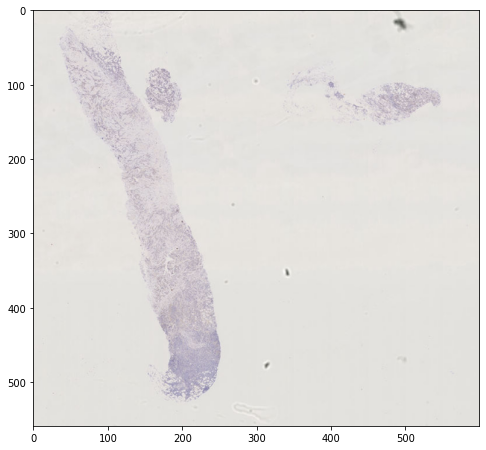

In [13]:
slide_thumb_600 = slide.get_thumbnail(size=(600, 600))
slide_thumb_600_np = np.array(slide_thumb_600)
plt.figure(figsize=(8, 8))
plt.imshow(slide_thumb_600_np)

##### 8. 查看图片文件中保存的层数和各层下图片的尺寸
WSI图片是一种金字塔结构，里面会保存许多层，最底层（0层）是原图，其他层一般都是以二分之一的尺寸进行缩小。

In [14]:
dims = slide.level_dimensions
num_levels = len(dims)
print("Number of levels in this image are:", num_levels)
print("Dimensions of various levels in this image are:", dims)

Number of levels in this image are: 9
Dimensions of various levels in this image are: ((49152, 45824), (24576, 22912), (12288, 11456), (6144, 5728), (3072, 2864), (1536, 1432), (768, 716), (384, 358), (192, 179))


##### 9. 查看每一层的缩放倍数

In [15]:
factors = slide.level_downsamples
print("Each level is downsampled by an amount of: ", factors)

Each level is downsampled by an amount of:  (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)


##### 10. 随机查看一个层的图片尺寸
这里使用了 slide.read_region()，意思是提取指定层下指定起始位置和大小的切片截图。
例子中，是查看了第三层（第一层是level 0），提取整个图片。

In [16]:
level3_dim = dims[2]
level3_img = slide.read_region((0, 0), 2, level3_dim)
print(level3_dim)

(12288, 11456)


##### 11. 可视化图片
Step1：将图片转换成RGB图像

Step2：如果后续需要对图片做进一步处理，需要将图片转成numpy格式

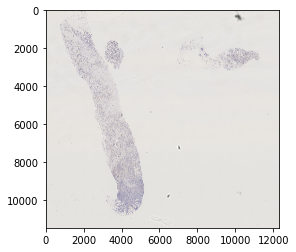

In [17]:
level3_img_RGB = level3_img.convert('RGB')
level3_img_np = np.array(level3_img_RGB)
plt.imshow(level3_img_np)

##### 12. 给定缩放尺寸，返回最合适的层数

In [18]:
SCALE_FACTOR = 32
best_level = slide.get_best_level_for_downsample(SCALE_FACTOR)
print(best_level)

5


##### 13. WSI切片
采用DeepZoomGenerator()，将WSI图片裁剪到指定的尺寸（如：512x512）。

实际上，这个操作还包含了很多其他的信息，它也包含了很多层，每个层也有各自不同大小的尺寸。

默认是最后一层，也就是在原图上进行裁剪。

In [19]:
tiles = DeepZoomGenerator(slide, tile_size=512, overlap=0, limit_bounds=False)
print("The number of levels in the tiles object are: ", tiles.level_count)
print("The dimensions of data in each level are: ", tiles.level_dimensions)
print("Total number of tiles = : ", tiles.tile_count)

The number of levels in the tiles object are:  17
The dimensions of data in each level are:  ((1, 1), (2, 2), (3, 3), (6, 6), (12, 12), (24, 23), (48, 45), (96, 90), (192, 179), (384, 358), (768, 716), (1536, 1432), (3072, 2864), (6144, 5728), (12288, 11456), (24576, 22912), (49152, 45824))
Total number of tiles = :  11555


##### 16. 在指定层上进行WSI切片

In [20]:
level_num = 16
print("Tiles shape at level ", level_num, " is: ", tiles.level_tiles[level_num])
print("This means there are ", tiles.level_tiles[level_num][0]*tiles.level_tiles[level_num][1], " total tiles in this level")

Tiles shape at level  16  is:  (96, 90)
This means there are  8640  total tiles in this level


##### 17. 查看指定层上提取一张切片的大小
下面例子中的（30，50）类似于矩阵的坐标，第30行第50列的切片。

In [21]:
tile_dims = tiles.get_tile_dimensions(16, (30, 50))
print(tile_dims)

(512, 512)


##### 18. 可视化切片

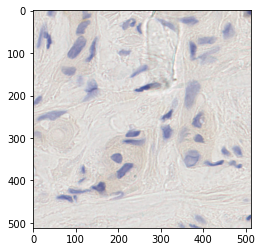

In [22]:
single_tile = tiles.get_tile(16, (30, 50))
single_tile_RGB = single_tile.convert('RGB')
single_tile_img_np = np.array(single_tile_RGB)
plt.imshow(single_tile_img_np)